## Milne-Eddington Inversions of a CRISP dataset

We are now going to work with filtergraph data. The main idea is the same, but now, modeling the transmission profile of the filter is really important. As we said, the spectral PSF is the part of our model, and even thought we are not fitting for it, we do have to account for it. 

Jaime de la Cruz prepared this example, and you can actually run it independently as a python script from the folder you cloned your pyMilne in.

In [2]:
# Standard suite of imports ;) 

import numpy as np
import matplotlib.pyplot as plt
import MilneEddington as ME
from astropy.io import fits

In [3]:
stokes = fits.open('/home/milic/codes/pyMilne/example_CRISP/crisp.6301_6302.2019-05-10_data.fits')[0].data

In [4]:
stokes.shape


(120, 350, 4, 30)

Look at that, 120 x 350 image, with 4 Stokes parameters, but only 30 wavelengths.

To see the spectra properly, since wavleengths are not sampled evenly, we have to load wavelengths too

In [5]:
ll = fits.open('/home/milic/codes/pyMilne/example_CRISP/crisp.6301_6302.2019-05-10_wave.fits')[0].data
print (ll)

[-1.27  -1.235 -1.2   -1.165 -1.13  -1.095 -1.06  -1.025 -0.99  -0.955
 -0.92  -0.885 -0.85  -0.815 -0.78  -0.745 -0.71  -0.24  -0.21  -0.18
 -0.15  -0.12  -0.09  -0.06  -0.03   0.     0.03   0.06   0.09   0.12 ]


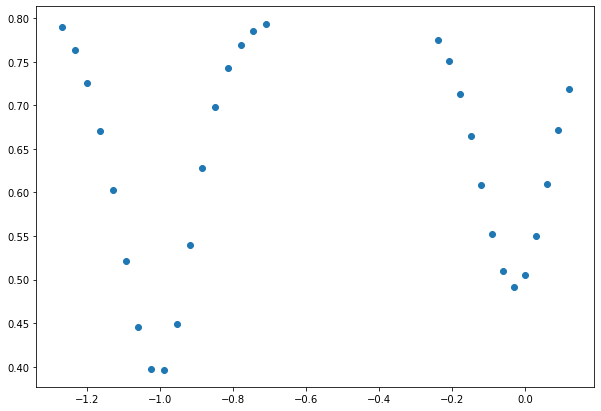

In [6]:
# Ok, these are obviously with respect to some referent wavelength (looks like 6302 :))

# Let's take a look at the mean spectrum:
mean = np.mean(stokes,axis=(0,1))

plt.figure(figsize=[10,7])

plt.plot(ll,mean[0],'o')
#print (np.diff(ll))

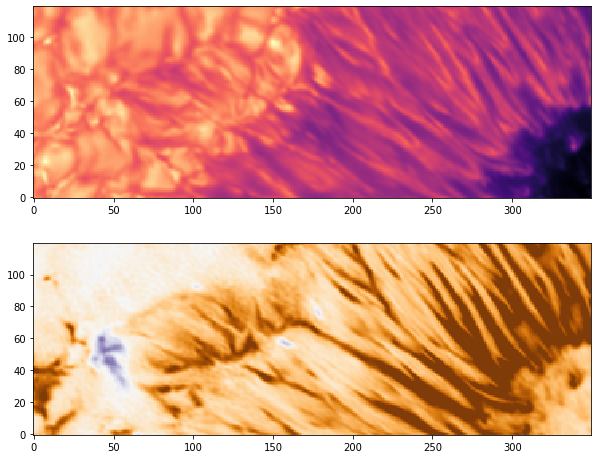

In [7]:
# Let's look at some images:
plt.figure(figsize=[10,8])
plt.subplot(211)
plt.imshow(stokes[:,:,0,0],cmap='magma',origin='lower')
plt.subplot(212)
plt.imshow(stokes[:,:,3,5],vmin=-0.1,vmax=0.1,cmap='PuOr',origin='lower')

Ok, the images at the individual wavelengths look good. But, remember, we are fitting all the wavelenghts together, therefore we need to properly account for the broadning of the filtergraph. 

The way to do that is: 

1) Create a new wavelength grid, which is nicely, evenly sampled at both of the filters, and contaings the observed points (this is tricky)

2) Perform calculations on this grid. Then convolve with the filter. 

3) Finally, perform inversion, taking only into account to points where the observation has actually been done. In practice, this is done by setting the noise level to the other points to something ridiculously high. Let's see how that works...

In [8]:
# This contains functions that calculate filtergraph profile
import crisp

In [9]:
# A function that will calculate the nice fine grid for us:
def findgrid(w, dw, extra = 5):
    
    """
    Findgrid creates a regular wavelength grid 
    with a step of dw that includes all points in 
    input array w. It adds extra points at the edges
    for convolution purposes

    Returns the new array and the positions of the
    wavelengths points from w in the new array
    """
    nw = np.int32(np.rint(w/dw)) # number of wavelengths
    nnw = nw[-1] - nw[0] + 1 + 2*extra # new number of wavelengths, including extras
    
    # wavelength grid
    iw = np.arange(nnw, dtype='float64')*dw - extra*dw + w[0]

    # this one is a bit abstract, but actually super useful
    # this one returns the indices of the points that are the closest to the original
    idx = np.arange(w.size, dtype='int32')
    for ii in range(w.size):
        idx[ii] = np.argmin(np.abs(iw-w[ii]))

    return iw, idx

To make all this clearer, let's try to use the function above:

In [10]:
# Refine our grid:
iw, idx = findgrid(ll, 0.005) #

In [12]:
print (iw)

[-1.29500000e+00 -1.29000000e+00 -1.28500000e+00 -1.28000000e+00
 -1.27500000e+00 -1.27000000e+00 -1.26500000e+00 -1.26000000e+00
 -1.25500000e+00 -1.25000000e+00 -1.24500000e+00 -1.24000000e+00
 -1.23500000e+00 -1.23000000e+00 -1.22500000e+00 -1.22000000e+00
 -1.21500000e+00 -1.21000000e+00 -1.20500000e+00 -1.20000000e+00
 -1.19500000e+00 -1.19000000e+00 -1.18500000e+00 -1.18000000e+00
 -1.17500000e+00 -1.17000000e+00 -1.16500000e+00 -1.16000000e+00
 -1.15500000e+00 -1.15000000e+00 -1.14500000e+00 -1.14000000e+00
 -1.13500000e+00 -1.13000000e+00 -1.12500000e+00 -1.12000000e+00
 -1.11500000e+00 -1.11000000e+00 -1.10500000e+00 -1.10000000e+00
 -1.09500000e+00 -1.09000000e+00 -1.08500000e+00 -1.08000000e+00
 -1.07500000e+00 -1.07000000e+00 -1.06500000e+00 -1.06000000e+00
 -1.05500000e+00 -1.05000000e+00 -1.04500000e+00 -1.04000000e+00
 -1.03500000e+00 -1.03000000e+00 -1.02500000e+00 -1.02000000e+00
 -1.01500000e+00 -1.01000000e+00 -1.00500000e+00 -1.00000000e+00
 -9.95000000e-01 -9.90000

Nice! Nice even sampling with 0.005 steps! 

In [14]:
print (idx)

[  5  12  19  26  33  40  47  54  61  68  75  82  89  96 103 110 117 211
 217 223 229 235 241 247 253 259 265 271 277 283]


Aha!  These oints that tell us which ones of the above are actually observed. Nice! 

Now, we could invert one line at the time, but let's just go all the way and invert them both simultaneously. For that, we will merge the both wavelength grids in one:

 Now, remember how the code works, we need to have equal number of wavelength points in the observations, wavelength and the noise. Let's do that now:

In [15]:
nx,ny = stokes.shape[0:2]
i = 0
j = 0
#nx = 20
#ny = 20

to_fit = np.zeros((nx,ny,4,iw.size), dtype='float64', order='c') 
    # Order c is actually a very nice little trick we can discuss

# This puts the original stokes values in the appropriate spots in to_fit array:
for s in range(4):
    for l in range(idx.size):
        to_fit[:,:,s,idx[l]] = stokes[i:i+nx,j:j+ny,s,l]


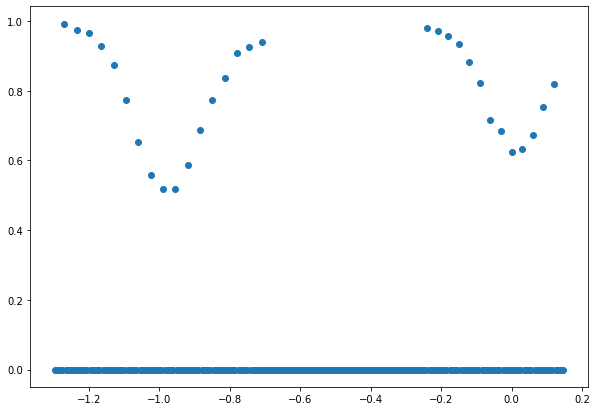

In [16]:
plt.figure(figsize=[10,7])
plt.plot(iw,to_fit[0,0,0],'o')

Now, let's make that noise array, to appropriately weight all the wavelengths:

In [17]:
noise= np.zeros((4,iw.size), dtype='float64') + 1.e34 # Huge noise everywhere
noise[:,idx] = 3.e-3 # except in the points we want to fit! 

# ^ Might be a bit non-intuitive, discuss in detail :) 

#
# Since the amplitudes of Stokes Q,U and V are very small
# they have a low imprint in Chi2. We can artificially
# give them more weight by lowering the noise estimate.
#
noise[1:3, idx] /= 10
noise[3, idx ] /= 3.5

Wow! A lot of work! Are we done already? No! We still need the instrumental profile to convolve this with! 

In [19]:
# Grids for both of the regions, we have them with different steps because
# different grid is used for the original observation
tw = (np.arange(75, dtype='float64')-75//2)*0.005
tr = crisp.crisp(6302.0).dual_fpi(tw, erh=-0.001)


crisp::read_reflectivity: (RL,RH)[6302.0] = (0.8387141054127902, 0.9356220400043067)


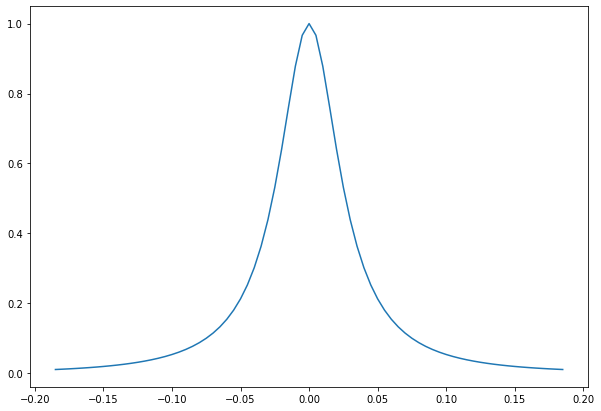

In [20]:
plt.figure(figsize=[10,7])
plt.plot(tw,tr)


There is an another confusing thing here. Why do the grids for transmission profiles have different width from the original wavelength ones? 

Remember that we are meant to convolve them, convolution does not worry about the number of points, it only cares about the spacing. 

In [21]:
%%time
# Almost there!

# Now, because sampling is different for the two lines, we have two different regions 
# Note that this was not necessary for the spectograph data
# Also, if you did not have to convolve, you would not have to have two different regions

# 6302.4931 is offset that we should know from the observation setup:
regions = [[iw + 6302.4931,tr/tr.sum()]]

lines = [6301,6302]
me = ME.MilneEddington(regions, lines, nthreads=8)

# guess model
guess_model = np.float64([1500, 2.2, 1.0, -0.5, 0.035, 50., 0.1, 0.24, 0.7])
guess_models = me.repeat_model(guess_model, nx, ny)

# Let's jam some inversions, again mu = 0.93 is something that we should know from the fits file
model_out, syn, chi2 = me.invert(guess_models, to_fit, noise, nRandom=5, nIter=25, chi2_thres=1.0, mu=0.93)

CPU times: user 26min 4s, sys: 3.86 s, total: 26min 8s
Wall time: 3min 41s


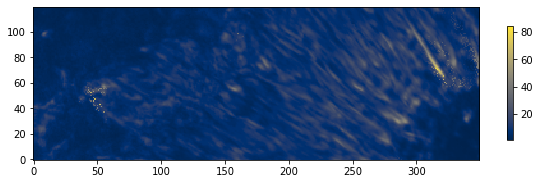

In [22]:
# Let's plot our chisquared:
plt.figure(figsize=[10,7])
plt.imshow(chi2,origin='lower',cmap='cividis')
plt.colorbar(shrink=0.3)

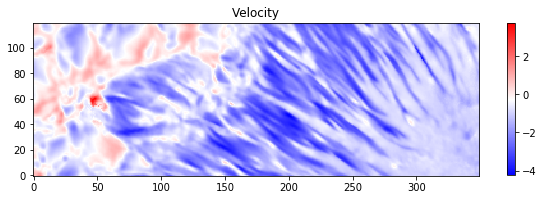

In [23]:
# Not the best fits, not the worst, let's see the parameters:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,3],origin='lower',cmap='bwr')
plt.title("Velocity")
plt.colorbar(shrink=0.4)

For sunspots, and in general for velocities, there are numerous "corrections" you can make to make this be meaningful. We can discuss these separately (what is zero velocity is actually a touchy question :))

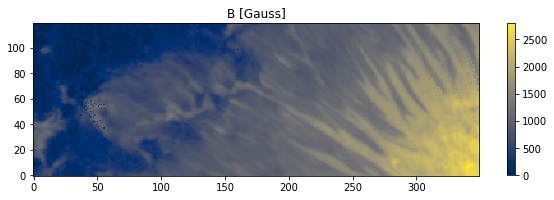

In [24]:
# Not the best fits, not the worst, let's see the parameters:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,0],origin='lower',cmap='cividis')
plt.title("B [Gauss]")
plt.colorbar(shrink=0.4)

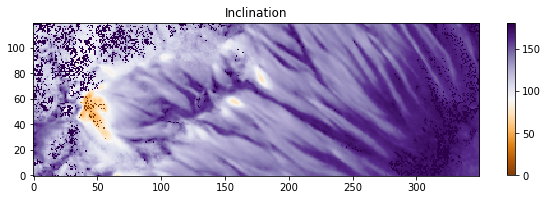

In [25]:
# Not the best fits, not the worst, let's see the parameters:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,1]*180./np.pi,origin='lower',cmap='PuOr')
plt.title("Inclination")
plt.colorbar(shrink=0.4)

In [26]:
from scipy.ndimage import gaussian_filter
model_smoothened = gaussian_filter(model_out,(3,3,0))

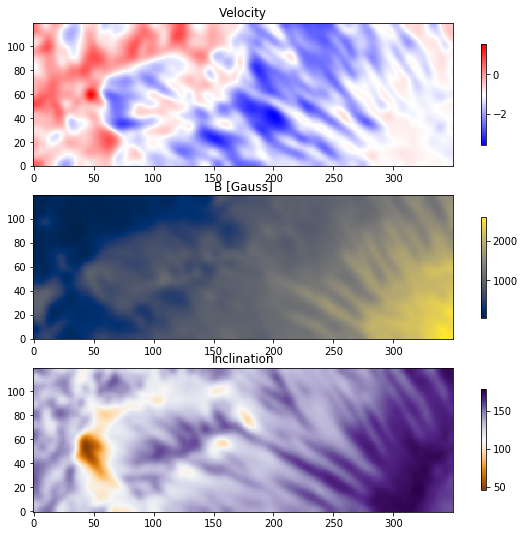

In [27]:
plt.figure(figsize=[10,9])
plt.subplot(311)
plt.imshow(model_smoothened[:,:,3],origin='lower',cmap='bwr')
plt.title("Velocity")
plt.colorbar(shrink=0.7)
plt.subplot(312)
plt.imshow(model_smoothened[:,:,0],origin='lower',cmap='cividis')
plt.title("B [Gauss]")
plt.colorbar(shrink=0.7)
plt.subplot(313)
plt.imshow(model_smoothened[:,:,1]*180./np.pi,origin='lower',cmap='PuOr')
plt.title("Inclination")
plt.colorbar(shrink=0.7)


7.810130164434586

In [29]:
model_out, syn, chi2 = me.invert(model_smoothened, to_fit, noise, nRandom=5, nIter=25, chi2_thres=5.0, mu=0.93)

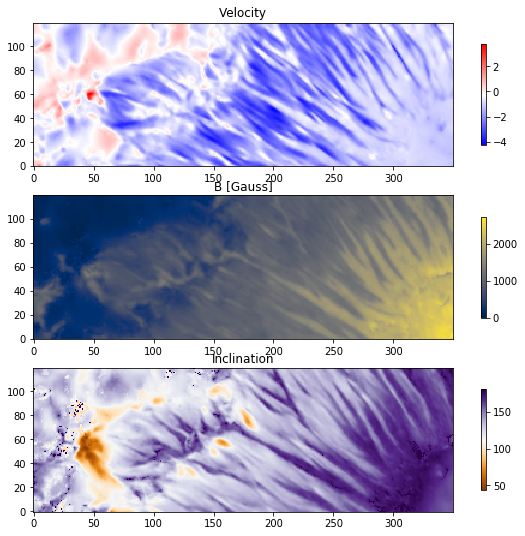

In [30]:
plt.figure(figsize=[10,9])
plt.subplot(311)
plt.imshow(model_out[:,:,3],origin='lower',cmap='bwr')
plt.title("Velocity")
plt.colorbar(shrink=0.7)
plt.subplot(312)
plt.imshow(model_out[:,:,0],origin='lower',cmap='cividis')
plt.title("B [Gauss]")
plt.colorbar(shrink=0.7)
plt.subplot(313)
plt.imshow(model_out[:,:,1]*180./np.pi,origin='lower',cmap='PuOr')
plt.title("Inclination")
plt.colorbar(shrink=0.7)

In [ ]:
model_smoothened = gaussian_filter(model_out,(2,2,0))
model_out, syn, chi2 = me.invert(model_smoothened, to_fit, noise, nRandom=10, nIter=25, chi2_thres=1.0, mu=0.93)

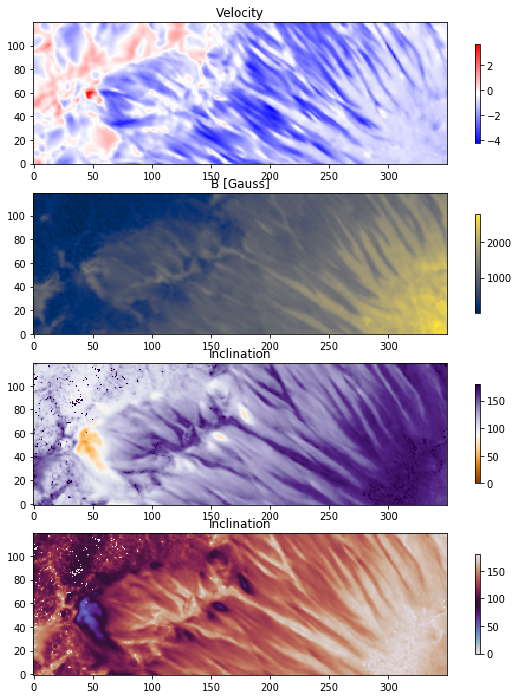

In [56]:
plt.figure(figsize=[10,12])
plt.subplot(411)
plt.imshow(model_out[:,:,3],origin='lower',cmap='bwr')
plt.title("Velocity")
plt.colorbar(shrink=0.7)
plt.subplot(412)
plt.imshow(model_out[:,:,0],origin='lower',cmap='cividis')
plt.title("B [Gauss]")
plt.colorbar(shrink=0.7)
plt.subplot(413)
plt.imshow(model_out[:,:,1]*180./np.pi,origin='lower',cmap='PuOr')
plt.title("Inclination")
plt.colorbar(shrink=0.7)
plt.subplot(414)
plt.imshow(model_out[:,:,1]*180./np.pi,origin='lower',cmap='twilight')
plt.title("Inclination")
plt.colorbar(shrink=0.7)

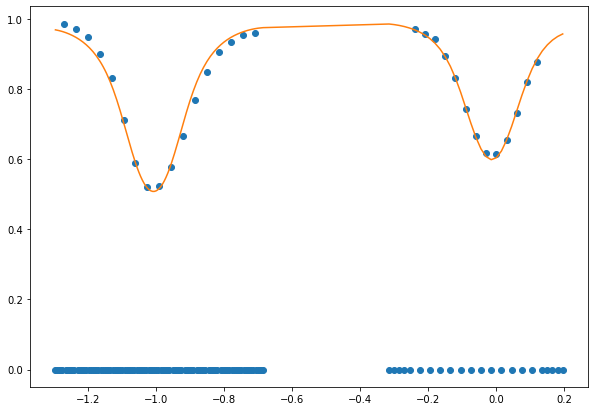

In [58]:
plt.figure(figsize=[10,7])
plt.plot(iw,to_fit[20,100,0],'o')
plt.plot(iw,syn[20,100,0])